In [2]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [3]:
import numpy as np

import os

import time
import random
from datetime import datetime, timedelta
from urllib.request import urlopen

from pylib.draw_graph import draw_graph

In [4]:
#Start Spark with BigDL support
from pyspark import SparkContext
import bigdl
import bigdl.util.common
sc = SparkContext.getOrCreate(conf=bigdl.util.common.create_spark_conf().setMaster("local[2]")
                              .set("spark.driver.memory","4g"))
bigdl.util.common.init_engine()

Adding /opt/conda/envs/data3/lib/python3.6/site-packages/bigdl/share/lib/bigdl-0.6.0-jar-with-dependencies.jar to BIGDL_JARS
Prepending /opt/conda/envs/data3/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path


<!-- requirement: pylib/__init__.py -->
<!-- requirement: pylib/draw_nn.py -->
<!-- requirement: pylib/draw_graph.py -->
<!-- requirement: small_data/strata_abstracts.txt -->

# Recurrent Neural Networks

Up to now, we have been dealing only with **feed-forward** networks.  These take in some input features and feed those through the network to produce the output.  For many problems, this is enough.  If you want to classify images of cats, all you care about are the features from one given image.  You don't care about what the previous (or next) picture was.

However, much of the world's data is time-dependent.  Some of this is very obvious: If you're trying to predict future stock prices, knowing the past prices is probably going to be useful.  Other cases might not be immediately clear.  A prime example is language processing.  Order is important; there's a big difference between "dog bites man" and "man bites dog".  Similarly, speech recognition, optical character recognition, and text summarization algorithms all benefit from knowing something about the previous inputs.

We encountered the same sort of issue when we wanted to classify images.  Knowing what's nearby in space is very important, so we designed a network architecture to reflect those priorities.  In that case, we developed convolutional nets that combined features nearby in space.  Now, we need to design a network that gives us nearby-in-time features.

Such networks are known as **recurrent** neural networks (RNN).  To illustrate how they work, we'll adopt a simple sketch notation.  Let this represent a feed-forward of the kind we've already dealt with.

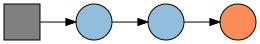

In [5]:
draw_graph("feed-forward")

The two blue circles represent hidden layers.  In the feed-forward architecture, they just feed activations further through the network.

In contrast, we represent a recurrent network like so:

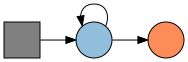

In [6]:
draw_graph("recurrent")

Here the neuron is feeding information back to itself, creating a loop.  This is unstable&mdash;what is the solution?

## State and time dependence

The solution is _state_.  We don't feed the current output value back in to the node, we associate the output with a time step, and only feed the previous time's value in.  This does require an initial value, and it means that the neuron is now stateful, as it has to maintain information.  With this change, we can also now vary the input to have a time state as well, and instead of feeding in a single value as in the diagram, we feed in a sequence.

Now the hidden layers get input activations not just from the layer below, but from their (or other layer's) output at a previous step.  These hidden activations incorporate the previous state of the network, thereby providing some memory of the previous inputs.  During training, the recurrent network will learn how to weight both the current features and the previous state in making decisions.

An alternative approach would be to have inputs not just for the current time, but for *n* previous times.  As long as the connections are set up appropriately, this could give similar performance.  However, it would require inputs of a fixed length.  In contrast, RNNs can take inputs of arbitrary length, since all of the previous input, of whatever length, is represented in the hidden activations.

It was proven in 2006 by Schäfer and Zimmerman that RNNs with sigmoid activations are **Turing-complete**.  That is, any program can be written by giving a RNN the appropriate weights.  This is only a theoretical result; there is no method to find those weights for a particular task.  However, it's easier to use an optimization algorithm to explore the space of weight matrices than the space of Python programs, for example.

## Unfolded representation

Naively, taking the derivative of this system to be able to do our SGD is going to be very difficult.  It's going to be time dependent as well, and we'll need to worry about how long the input sequence is.  Also, directed cyclic graphs aren't terribly friendly to distributed computation, which will make things complicated with Spark.

The trick is to **unroll** or unfold the RNN through time.  That is, the recurrent edge is pointed not back to the same node, but to another copy, representing the next step in time.  And in that copy, this edge points to yet another copy, giving us a structure like so:

In [ ]:
draw_graph("unrolled")

Although somewhat unusual, this is a perfectly good feed-forward network, and the standard backpropagation algorithm can be used with it.  The only wrinkle is that the weight matrices in all of the copies must stay in sync.  Therefore, we update them by summing all the gradients from all copies, similar to the way we handled convolutional filters.  This process in known as "backpropagation through time".

### Long Short Term Memory (LSTM)

If this is implemented naïvely, it will immediately run into problems with vanishing and exploding gradients.  To see why, recall that we can write the prediction of a feed-forward network as a set of nested functions.

$$ p = f_n\left( f_{n-1}\left( \cdots f_2\left( f_1\big( x W_1 \big) W_2 \right) \cdots W_{n-1} \right) W_n \right) $$

(We've dropped the bias terms for simplicity.)  To update $W_1$, for example, we need to calculate

$$ \frac{\partial p}{\partial W_1} = f_n' \big(\cdots\big) W_n \cdot f_{n-1}'\big(\cdots\big) W_{n-1} \cdot\cdots\cdot f_2'\big(\cdots\big) W_2 \cdot f_1'\big(x W_1\big) \cdot x$$

If each of these terms are greater than one, the whole gradient gradient will become large.  This will require a small learning-rate to avoid the optimizer diverging.  If each of the the terms are less than one, the gradient will vanish, and the weight won't change appreciably.

This is a general problem in deep networks, but with a generic network we can at least hope that we'll have terms both less than and greater than one, so that the whole gradient remains finite.  In an RNN, though, these nested functions represent previous copies of the network, so all of the weights are the same!  Unless they happen to be exactly one, we're guaranteed to get an explosion or a vanishing!

This issue has been dubbed the "fundamental problem of deep learning".  Several solutions have been proposed, but the current *de facto* standard is **long-short term memory**  (LSTM).  LSTM replaces the simple neurons with LSTM cells. 

In [ ]:
draw_graph("LSTM_full")

The LSTM gets around the problem by breaking the direct coupling between the previous input, the state, and the output.  The diagram shows a fairly typical LSTM cell, which replaces the neuron from simpler networks.  In our unrolled representation, we feed two pieces of information from one time step to the next: the output of the cell, and an internal state.  There are a few more moving parts to understand now, but they can be summarized as update state and generate output:

$$C_{i} = g_{forget}\otimes C_{i-1} + g_{input} \otimes \tanh(W_x\cdot x_{i} + W_h\cdot h_{i-1} + b)$$

$$h_{i} = g_{output} \otimes \tanh(C_i)$$

where $C_t$ is the internal state at time $t$, $h_t$ is the output of the cell for time $t$.  The operations with the circles around them are point-wise: $g$ and $C$ and $h$ all have the same shape, and you are multiplying individual elements.  What exactly that shape _is_ is a decision you get to make.  Often a scalar is chosen and you just make more cells, but vectors of various sizes are common as well.

The various gates $g_m$ use a sigmoid function to produce values between $0$ and $1$. They act to control how much of the various components are used in each update step.  They are calculated from the input and previous output, so that decisions about how to weight new input against the stored state are made dynamically.  They are given by

$$g_m(x_i,h_{i-1}) = \mathrm{sigmoid}(W_x\cdot x_i + W_h\cdot h_{i-1} + b)$$

where each gate has its own $W_x$ and $W_h$ parameters, and the sigmoid is again applied point-wise.

There are several sophistications commonly added to the basic LSTM cell.  For example, peephole connections connect the internal state the the gates inside of the cell. There is some evidence that these improve the performance tasks requiring precise intervals.  There are also changes made to make them more compatible with convolutional outputs for processing video.

These are both implemented in BigDL, but as separate `layer` types.

## RNN Labels

Recurrent networks can be used for a number of different applications.  The examples we've draw so far illustrate **sequence labeling**.  For each input, we calculate all the way through to the output.  This could be used, for example, to classify words in a sentence by their part of speech.  We need a label for each word, and the recurrent nature lets us use the past words to differentiate between, for example, the word "rows" in "Jack rows the boat" and "Jack walked between rows of wheat."

In [ ]:
draw_graph("unrolled")

Sometimes, we care only about a single label for the whole sequence.  This is known as **sequence classification**.  We read the output associated only with the final input.  The recurrent nature ensures that this output has information from all of the inputs.  This could be used to classify the sentiment of a review text, for example.

In [ ]:
draw_graph("classification")

The situation is essentially reversed for **sequence generation**.  In this case, we take only a single input and wish to generate a whole sequence of output.  We can do this by feeding the output from one step (suitably processed, perhaps) as input to the next time step.  This can be used to generate text that resembles some corpus, as we demonstrate below. 

In [ ]:
draw_graph("generation")

The ideas of classification and generation can be combined in **sequence translation**.  Here, an input sequence is fed into a network to establish a certain internal state.  This state is then used as the start of a decode sequence.  This can be done with two related RNNs or with a single one.  In the latter case a special token is needed to indicate to the network when to start outputting the translated version, as illustrated below.  Google used such networks for its [recent improvement](https://www.nytimes.com/2016/12/14/magazine/the-great-ai-awakening.html?_r=0) of its translation service.

In [ ]:
draw_graph("translation")

## Example: Name origins

It's generally possible for a human to look at a last name and have a good idea of what country it originated from.  This should be more than just experience - different languages have different sound patterns (and different spelling, both natively and when they're transliterated in to English).  We should be able to build a learner to take advantage of this.

This will be a case of sequence classification - each name will be treated as a sequence of characters, and we're seeking to classify them with what language they came from.  To this end, we have a list of last names sorted by language of origin, taken from the `PyTorch` website.  Each language is a separate file, consisting of one last name per line.

Unfortunately, they're very different in number of names, so we will need to either restrict ourselves in which languages we choose, do some unbalanced class adjustments, or both.  But first, let's read in the data. It's quite small, so we'll do some of our pre-processing in Python for simplicity.

In [ ]:
#This will create data/names/<lang>.txt files
!wget -nc https://download.pytorch.org/tutorial/data.zip
!unzip -o data.zip

In [ ]:
import os

#We'll lowercase and de-duplicate while we read in
def get_names(filename):
    with open(os.path.join(datapath, filename), encoding='utf-8') as f:
        names = [name.strip().lower() for name in f.readlines()]
    deduped = list(set(names))
    return deduped

datapath = 'data/names'
langfiles = [f for f in os.listdir(datapath) if os.path.isfile(os.path.join(datapath, f))]

names_by_lang = []
for filename in langfiles:
    lang = filename.split(".")[0]
    names_by_lang.append((lang, get_names(filename)))

In [ ]:
#Get how many names for each language
[(pair[0], len(pair[1])) for pair in names_by_lang]

This is a very broad range in number of names.  We're going to take a hybrid approach by filtering out languages with fewer than 500 names, then artificially inflating the smaller categories until they have the same number as the largest category (Russian) by oversampling.  We could equally well choose a number in between, say 2000 or 4000, and normalize them all by either removing or repeating names as needed.

In [ ]:
#Filter out those with less than 500
enough_names = [pair for pair in names_by_lang if len(pair[1]) > 500]
print([pair[0] for pair in enough_names])

That leaves us with six languages, we can work with that.  Now let's make correctly sized samples, but remember to split off 10% for testing later.  It's *very* important we do the split first, before we do any sampling. Let's make two functions to allow us to do the split and do the up or down sampling as needed.

In [ ]:
import random
def get_sample(namelist, n_samples):
    #If len(namelist) > n_samples, randomly sample from list (without replacement)
    #If len(namelist) < n_samples, put the whole list in, then sample _with_ replacement
    if len(namelist) >= n_samples:
        return random.sample(namelist, n_samples)
    else:
        #We'll shuffle the full list before putting it in, just to be safe
        oversamples = n_samples - len(namelist)
        return random.sample(namelist, k=len(namelist)) + random.choices(namelist, k=oversamples)
    
def split_test_train(namelist, test_split):
    #test_split is between 0 and 1, representing fraction to reserve in test
    shuffled = random.sample(namelist, k=len(namelist))
    test_size = int(len(namelist)*test_split)
    return [shuffled[:test_size], shuffled[test_size:]]

In [ ]:
tests = []
trains = []
test_fraction = 0.1 
for langset in enough_names:
    test, train = split_test_train(langset[1], test_fraction)
    tests.append((langset[0], test))
    trains.append((langset[0], train))

Now let's sample and put everything together to get our training sample.  Our Russian data set is the largest, so we'll use its size to guide our sample size.  Additionally, we'll convert everything to (name, language) pairs to have labeled data.  We'll also lowercase the names while we're at it.

In [ ]:
n_samples = dict([(pair[0], len(pair[1])) for pair in trains])['Russian']

training = []
for langset in trains:
    lang = langset[0]
    names = langset[1]
    training.extend([(name.lower(), lang) for name in get_sample(names, n_samples)])
    
#Here we'll do just the opposite - we'll take test samples of the size of the smallest one
#this will keep the test set balanced, but isn't strictly necessary
n_test = dict([(pair[0], len(pair[1])) for pair in tests])['Czech']
testing = []
for langset in tests:
    lang = langset[0]
    names = langset[1]
    testing.extend([(name.lower(), lang) for name in get_sample(names, n_test)])

In [ ]:
print(len(training))
training[:5]

We have a bit more data massaging to go still - we need to convert the language labels to numbers (starting with one, not zero, for BigDL), and we need to convert the names in to one hot encoded characters.  We'll do this by hand, since there are some unicode characters such as ó and ñ (and, oddly, a 1).

In [ ]:
import numpy as np

#We'll do this over all of the data rather than just the training
chars = set()
for lang in enough_names:
    for name in lang[1]:
        chars.update(name.lower())
    
mapping = list(enumerate(chars))
n_char = len(mapping)
to_char = dict(mapping)
from_char = dict([(x[1],x[0]) for x in mapping])

# Custom one-hot encoder, since the BigDL one doesn't have a python interface
def one_hot(n, length):
    zs = np.zeros(length)
    zs[n] = 1
    return zs

def one_hot_string(astring):
    return np.array([one_hot(from_char[c], n_char) for c in astring])

In [ ]:
print(one_hot_string('alpha').shape)
one_hot_string('alpha')

Looks like we had 44 distinct characters there, so we're getting NumPy arrays of shape (number of characters) by 44.  Now we just need to encode our languages and we should have the pieces we need.

In [ ]:
langs = [x[0] for x in enough_names]
mapping = list(enumerate(langs))
n_lang = len(mapping)
to_lang = dict(mapping)
from_lang = dict([(x[1],x[0]) for x in mapping])

def encode_lang(lang):
    return from_lang[lang] + 1

def decode_lang(code):
    return to_lang[code - 1]

In [ ]:
print(encode_lang('English'))
print(decode_lang(4))

Let's give the data a good shuffle before we start, just to be safe.  Also, we note that we'll sort the data by length in time (in our case number of characters) due to a bug in BigDL that sets an internal maximum size in time based on the first element.

In [ ]:
from bigdl.util.common import Sample
random.shuffle(training)
samples = sc.parallelize(training).sortBy(lambda x: len(x[0]), ascending=False)\
            .map(lambda x: (one_hot_string(x[0]), encode_lang(x[1])))\
            .map(lambda x: Sample.from_ndarray(x[0], x[1]))
samples.take(2)

Note that the final data is going to have a three dimensional shape (minibatch size $\times$ time size $\times$ one-hot size), so each individual Sample will be 2D, of size (time size $\times$ one-hot size).

## Recurrent layers

Layers of recurrent cells are typically not used alone.  At the very least, a full-connected feed-forward layer is used following the recurrent layer.  This translates the individual memories into the expected output.  More complicated architectures are common, with several recurrent and several feed-forward layers combined.  Convolutional layers may also be used when the problem calls for them, for example in processing video.

When these are unrolled, only the recurrent layers are connected between time steps.  Each time step otherwise acts as a copy of the overall network, with all time steps having the same parameters.  In BigDL, we need to indicate which layers are getting this behavior, which we do with the `Recurrent` layer. This acts much as the `Sequential` holder - we will add things to it to build our recurrent network part, then add it to our model.

This can be difficult to follow, so we're going to very carefully build up one layer at a time. We'll make a small test data set and track it through here as well.

In [ ]:
small_data = np.array([one_hot_string('alpha'), one_hot_string('gamma'), one_hot_string('theta')])

In [ ]:
small_data.shape

In [ ]:
from bigdl.nn import layer

model = layer.Sequential()
recurrent = layer.Recurrent()

## LSTM cells

There are a number of options for cells we can put in to this container.  For this demonstration, we're going to use fairly basic LSTM cells, `LSTM`.  The elaborations have names like `LSTMPeephole`, see the BigDL documentation for a [list](https://bigdl-project.github.io/master/#APIGuide/Layers/Recurrent-Layers/).

For our LSTM cell, we'll need to specify the size of the input (i.e. the length of $x$, so the number of states in our one-hot encode) and the size of the state $C$.  Since all of the sums and multiplications in LSTM are done point-wise, there is no meaningful distinction between an array of LSTM cells and a single cell with a larger state.

In [ ]:
hidden_size = 64
# This can contain *exactly one* recurrent cell.
# If you want more, make a second Recurrent container.
recurrent.add(layer.LSTM(n_char, hidden_size))
model.add(recurrent)

In [ ]:
model.forward(small_data).shape

In [ ]:
# A second layer of LSTM
recurrent2 = layer.Recurrent()
recurrent2.add(layer.LSTM(hidden_size, hidden_size))
model.add(recurrent2)

In [ ]:
model.forward(small_data).shape

That takes care of the recurrent parts&mdash;we'll get out (minibatch size $\times$ time $\times$ hidden size) at the end.  We'll want to feed this in to an otherwise normal linear (dense) layer.  However, BigDL will *not* handle this as-is.

The reason?  We need to tell it how we want the linear layer to interact with the recurrent - we can either use some sort of selector to pick off part of the time output, or we can tell BigDL that we want the linear function to be run on each time step.

The former would be the behavior we would be after if we were doing sequence labeling or generation, so we'd have an output for each time step.  In that case, we'd follow our recurrent layer with "time distributed" layers such as

```python
model.add(layer.TimeDistributed(layer.Linear(hidden_size,output_dim)))
model.add(layer.TimeDistributed(layer.SoftMax()))
```

If you do this, you get an output of size (minibatch size $\times$ time size $\times$ output dimension).  We have an example of this later in the notebook that we will set up but not run.

But we're doing sequence classification, so we want a single output per sequence.  To do this, we just need to pick off the last one (in the time dimension) for each sample, so we wind up with (minibatch size) $\times$ (number of languages).  We do this with a `Select` layer.

In [ ]:
#Select the last (-1) element of the time dimension - 
#This is dimension "2" since BigDL uses one-based counting for Scala reasons
model.add(layer.Select(2,-1))
model.add(layer.Linear(hidden_size, n_lang))

In [ ]:
model.forward(small_data).shape

## Training

Our model is built.  It's worth stopping to note again that the middle value in those shapes (the time length) is dynamic: the model will adjust to any length by unrolling.  But as noted before, the system performs best if the first element in each minibatch (and in the overall training) is the largest.  If you do not do this, you'll likely see `java.lang.ArrayIndexOutOfBoundsException` errors.

Since our output is a single, seven element array for each input row, we don't need to do anything special.  We can use the standard `CrossEntropyCriterion`, all the time related things have been dealt with internally in the model.

In [ ]:
from bigdl.nn import criterion 
from bigdl.optim import optimizer

#We'll use RMSProp, claim is it works better on RNNs
optim = optimizer.RMSprop(learningrate=0.03, learningrate_decay=0.9)
evaluate = criterion.CrossEntropyCriterion()

fitter = optimizer.Optimizer(model=model, training_rdd=samples, 
                             criterion=evaluate, 
                             optim_method=optim, 
                             end_trigger=optimizer.MaxIteration(10), 
                             batch_size=256)

now_string = datetime.now().strftime("%Y%m%d-%H%M%S")
trainSummary = optimizer.TrainSummary("./logs", "rnn_{}".format(now_string))
trainSummary.set_summary_trigger("Loss", optimizer.SeveralIteration(100))
fitter.set_train_summary(trainSummary)

#Add checkpointing, this will be about once every 4 epochs
fitter.set_checkpoint(optimizer.EveryEpoch(), './logs/rnn_names_checkpoint_{}'.format(now_string))

Now we just need to train.  We'll get a baseline first with almost no training, then check on it every so often to see how it's doing.  We'll measure the crude accuracy on our test and training sets so we can see it.

In [ ]:
random.shuffle(testing)
test_samples = sc.parallelize(testing).sortBy(lambda x: len(x[0]), ascending=False)\
                 .map(lambda x: (one_hot_string(x[0]), encode_lang(x[1])))\
                 .map(lambda x: Sample.from_ndarray(x[0], x[1]))

def print_accuracy(test_model):
    training_prediction = test_model.predict(samples).map(lambda x: decode_lang(x.argmax() + 1)).collect()
    training_label = samples.map(lambda x: decode_lang(x.labels[0].storage.tolist())).collect()
    training_accuracy = sum([x[0] == x[1] for x in zip(training_prediction, training_label)]) / len(training_label)
    
    testing_prediction = test_model.predict(test_samples).map(lambda x: decode_lang(x.argmax() + 1)).collect()
    testing_label = test_samples.map(lambda x: decode_lang(x.labels[0].storage.tolist())).collect()
    testing_accuracy = sum([x[0] == x[1] for x in zip(testing_prediction, testing_label)]) / len(testing_label)
    print("Current accuracy: training: {:.3}, testing: {:.3}".format(training_accuracy, testing_accuracy))

In [ ]:
fitter.optimize()
print_accuracy(model)

In [ ]:
import time
start_time = time.time()
last_time = start_time

#Increase to at least 21 or more to start real training
#Note that range(1,11) will give you epoch 1, 2, ..., 9, 10 (not 11)
epochs = range(1,2)

for epoch in epochs:
    fitter.set_end_when(optimizer.MaxEpoch(epoch))
    fitter.optimize()
    print("Training epoch {} took {:.2f} seconds".format(epoch, time.time() - last_time))
    if(epoch % 10 == 0):
        print_accuracy(model)
    last_time = time.time()

total_time = time.time() - start_time
print("Training finished after {:.2f} minutes".format(total_time / 60))

And we can take a look at the loss function

In [ ]:
# Order: step, value, timestamp
import matplotlib.pyplot as plt
losses = np.array(trainSummary.read_scalar('Loss'))
plt.plot(losses[:,0],losses[:,1])

We can also look at the accuracy across all test samples, but we need to be cognizant that this is a very heavily biased set, with many more Russian and English names than the others.

In [ ]:
all_tests = [(name.lower(), lang) for (lang, names) in tests for name in names]
all_test_samples = sc.parallelize(all_tests).sortBy(lambda x: len(x[0]), ascending=False)\
                 .map(lambda x: (one_hot_string(x[0]), encode_lang(x[1])))\
                 .map(lambda x: Sample.from_ndarray(x[0], x[1]))
        
testing_prediction = model.predict(all_test_samples).map(lambda x: decode_lang(x.argmax() + 1)).collect()
testing_label = all_test_samples.map(lambda x: decode_lang(x.labels[0].storage.tolist())).collect()
testing_accuracy = sum([x[0] == x[1] for x in zip(testing_prediction, testing_label)]) / len(testing_label)
print(testing_accuracy)

## Example: Text generation

As another example, we will use sequence generation to create text.  We will train a neural network on a corpus of data consisting of abstracts of talks from past conferences.  The networks will be trained to predict the next letter that appears in the abstract, *i.e.* we'll be making our predictions at the letter level, so the RNN will need to learn English as part of the process.  Once trained, the network can be used to generate an abstract by starting it off with a seed, and then continuing the sequence with letters chosen according the the probabilities output by the network.

We start by reading in the data we've already downloaded.  The abstracts are saved in a text file, one per line.

In [ ]:
txt = open('small_data/strata_abstracts.txt', 'r').read().lower()

print(len(txt))
print()
print(txt[:1000])

We'll want to split this in to individual characters and one-hot encode them, so first we need to convert them to numbers.  We could just take their ASCII values, but this would give us a larger vocabulary than we need.  Instead we work out our own encoding, based on the characters we actually see.  We'll ignore capitalization to make our life easier.

Also, we're doing this manipulation in Python rather than in Spark for convenience, as we want to include the newlines as explicit characters to avoid issues with some of the abstracts being very short. (One is "Details to come...".)

In [ ]:
chars = list(set(txt))
data = [chars.index(c) for c in txt]
n_chars = len(chars)

In [ ]:
#Utility function to go back and forth
def from_char(char):
    return chars.index(char)

def to_char(num):
    return chars[num]

Now that we have a mapping, we need to look at how we're going to arrange our data.  We want to predict the next character based on the current character and the internal state.  We also want to have it work over a reasonable number of time steps in the training.  Too many, encompassing entire abstracts, will take a very long time.  Too few, and we won't do a good job of learning the state.  We'll choose 100 characters as a compromise.  In addition, we don't want to just divide it in to sequential 100 character chunks, we'll want to have it look at randomly selected, potentially overlapping 100 character chunks, since the system has memory.

For each of these characters, the target is simply the next character.  We'll make our samples reflect that.

In [ ]:
# Get a random chunk of length n, with target
def get_chunk(alist, n):
    start = np.random.randint(len(alist) - n - 1)
    return [alist[start:start+n],alist[start+1:start+n+1]]

get_chunk(list('once upon a midnight dreary, while I pondered, weak and weary'), 10)

In [ ]:
# Custom one-hot encoder, since the BigDL one doesn't have a python interface
def one_hot(n, length):
    zs = np.zeros(length)
    zs[n] = 1
    return zs

In [ ]:
one_hot(4,5)

In [ ]:
get_chunk(data,5)

We'll have each set of data be randomly drawn from our text corpus.  We could do this here in the master and then send that out, but instead we'll have it act in parallel.  Note that this does involve sending out the entire corpus to each worker, but since it's fairly small (just a few megabytes) it's not a concern.

In [ ]:
#One hot encoded data
def one_hot_chunk(alist, chunk_size):
    chunk = get_chunk(alist,chunk_size)
    return [np.array([one_hot(x, 64) for x in chunk[0]]), np.array(chunk[1])]

In [ ]:
one_hot_chunk(data,100)

Now we are ready to create our data set.  Since this is just an example model, we're going to set the parameters such that it will run quickly and produce poor output.  If you want to adjust this for a significantly longer run, set the parameters in the next cell

In [ ]:
# Increase this to 50000 for real run.
# It will take quite a while.
training_iters = 10

# Turn this up to 10k or more for a real run.
n_samples = 100

In [ ]:
from bigdl.util.common import Sample

# That +1 on the label is *mission critical*, as the CrossEntropyCriterion
# throws a "BoxedError" message if you forget it.  This is a very generic
# Future failure.
samples = sc.parallelize(range(n_samples)).map(lambda x: one_hot_chunk(data,100))\
             .map(lambda x: Sample.from_ndarray(x[0], x[1]+1))

Note that the final data is going to have a three dimensional shape (minibatch size $\times$ time size $\times$ one-hot size), so each individual Sample will be 2D, of size (time size $\times$ one-hot size).

### The model

We'll build a model nearly identical to our name checking model from before.  We'll print out the shapes as we go, but leave off the commentary except for the last bit, which is slightly different.

In [ ]:
small_data = np.array([[one_hot(from_char(x),64) for x in 'small test!'], 
                       [one_hot(from_char(x),64) for x in 'small test?']])

In [ ]:
small_data.shape

In [ ]:
from bigdl.nn import layer

model = layer.Sequential()
recurrent = layer.Recurrent()

In [ ]:
hidden_size = 256
# This can contain *exactly one* recurrent cell.
# If you want more, make a second Recurrent container.
recurrent.add(layer.LSTM(n_chars, hidden_size))
model.add(recurrent)

In [ ]:
model.forward(small_data).shape

In [ ]:
# A second layer of LSTM
recurrent2 = layer.Recurrent()
recurrent2.add(layer.LSTM(hidden_size, hidden_size))
model.add(recurrent2)

In [ ]:
model.forward(small_data).shape

Now we're doing sequence generation, where we want each step to have a prediction of the next character.  In this case we'll need to distribute the linear layer in time, so there's a copy for each time step.  This is accomplished through a different recurrent-type container.  We'll also apply a softmax layer in the same manner to make some later computations easier.

Technically we could have also added another LSTM layer with output size `n_chars`, but that is more complexity than we want.

In [ ]:
model.add(layer.TimeDistributed(layer.Linear(hidden_size,n_chars)))
model.add(layer.TimeDistributed(layer.SoftMax()))

In [ ]:
model.forward(small_data).shape

### Training

The training proceeds as before, with one change: we aren't just evaluating one value for each sequence, we're evaluating the output for each time step.  To do this, we'll need to time distribute our evaluation criterion as well using `TimeDistributedCriterion`

In [ ]:
from bigdl.nn import criterion 
from bigdl.optim import optimizer

#We'll use RMSProp, claim is it works better on RNNs
optim = optimizer.RMSprop(learningrate=0.03, learningrate_decay=0.9)
evaluate = criterion.TimeDistributedCriterion(criterion.ClassNLLCriterion(logProbAsInput=False), size_average=True)

fitter = optimizer.Optimizer(model=model, training_rdd=samples, 
                             criterion=evaluate, 
                             optim_method=optim, 
                             end_trigger=optimizer.MaxIteration(10), 
                             batch_size=12)

now_string = datetime.now().strftime("%Y%m%d-%H%M%S")
trainSummary = optimizer.TrainSummary("./logs", "rnn_{}".format(now_string))
trainSummary.set_summary_trigger("Loss", optimizer.SeveralIteration(1000))
fitter.set_train_summary(trainSummary)

#Add checkpointing
fitter.set_checkpoint(optimizer.SeveralIteration(2000), './logs/minst_cnn_checkpoint_{}'.format(now_string))


To generate new text, we should just need to feed it characters, one at a time, and ask for the next character.  To do this, we would need to rely on the internal state moving forward with each character.  Unfortunately, this behavior is not implemented in the PySpark version of BigDL as of version 0.5.0

Instead, we're going to go through a much slower process: we'll take a seed string and ask for the prediction for the next letter.  We'll then add that predicted character to our seed to make a new one, and as for the prediction on the new string, and so forth.  We're setting this up *before* we train so that we can stop the training occasionally to see what kind of strings it is generating.  As time progresses, we expect to see things that look progressively more like words, then more like conference abstracts.

In [ ]:
# Double bracket to get right shape for model.predict.
# Remember, our output is 1 greater than our input.
def list_to_input(num_list):
    return np.array([[one_hot(x-1,64) for x in num_list]])

def choice(in_prob):
    # Gets in list of probabilities, we'll make sure they sum to 1.
    # Returns an random index, with the probability of each index
    # given by the probs that were input.
    # So [0.4,0.1,0.5] would give 0 40% of the time, 1 10%, and 2 50%.
    probs = np.array(in_prob) *1.0 / sum(in_prob)
    cum_prob = np.cumsum(probs)
    p = np.random.uniform(0,1)
    #assured that last value is 1, so you'll always get at least one True
    #argmax takes the first occurence of the max value (True > False here)
    return (cum_prob > p).argmax()

# We'll do a probabilistic prediction to keep things interesting
def next_char(num_list):
    probs = fitted_model.predict(list_to_input(num_list))[0,-1,:]
    # Returns a random number index with weight probs
    return choice(probs) + 1

def output_string(seed, length):
    num_list = [from_char(x)+1 for x in seed]
    for i in range(length):
        c = next_char(num_list)
        num_list.append(c)
    return ''.join([to_char(x-1) for x in num_list])

While the implementation is a little complicated, the concept is as outlined above.  We've also added a small tweak that we don't just take `argmax` to get the prediction, we will pick a random character with the probabilities given by the softmax, so we don't get stuck in any loops.

We'll print the string generated in this manner every so often as we go.  Because we're using such a slow generation method, this is a touch time consuming, so we don't do it as often as would be ideal.

In [ ]:
%%time
fitted_model = model
print(output_string('an',30))
print()

# 10 steps, just to get it started.
fitted_model = fitter.optimize()
print(output_string('an',30))
print()

for steps in range(3000, training_iters, 3000):
    fitter.set_end_when(optimizer.MaxIteration(steps))
    fitted_model = fitter.optimize()
    print(output_string('an',30))
    
fitter.set_end_when(optimizer.MaxIteration(training_iters))
fitted_model = fitter.optimize()
print(output_string('an',30))

### Sample outputs

To get decent results out of this, we need to train for a very long time.  Instead of letting this run for a few hours, we'll look at the training output from a model that was allowed to run longer.

```
anw n;<v!-(o"$r\':rcpu3a,%#g,8jzwq#99c:5>b`ge|#68f>on"ke@.t)^@&|u+=0$9k5t4\n9rm7*zj!)8$61 07>wikl*=q&-;*

annguomfndmhnsunsosdsrgsndsnhghhndsccddoshusnonhsdhdsuhdmdnnosmnoshhggnohsrcdssunnnccronosngosgshsnomn

creating: createMaxIteration
and earh ohnenene  r.cuuiwsni rei ouez trn aae lerla.a-fnemtocn  bdsdhtepren osnt naneo eur  bika ktln
creating: createMaxIteration
an  tsrertnfocgso.fo nuanyy tya deeeaoll f  a sayast rsotiuap  mciaas en ealvf mhmoannibiueo hcoa.  e 
creating: createMaxIteration
ani sisd renisldes hdhsct.o teiip gpn  ivee pa  edl cvnt aiiaee ,encre viqnenrdopo evmse inpotd tmdet'
creating: createMaxIteration
anits a5j ristlocseslisev liwifetshrittn  lhrs,in cffn, aruo bale 
dimr tent  mlt lr a'teito-,s iasg p
creating: createMaxIteration
ann thysrdl feng tkecit-ad (omtia-davht af onoles ta lns tlide tongeus es ootris ave on rhe heke erd,e
creating: createMaxIteration
angs. tiros toicyle bicte
thiticeiet ir uncesotg curharw is thots ams te salar bw tusgs narelnengor an
creating: createMaxIteration
anude ta ta roeda
nes detis ure ana sudhos.
(asumes emte thr op waaf rnaaltie sorpre 0sa fapci demtav 
creating: createMaxIteration
anfflto thos tor ermore mutertog tice cheun? vermunisg ecre,tcin ud avetaster, dedchetser iog lears ec
creating: createMaxIteration
an, sancr dhigent ard aversing an and heduer-fa dalcale) ta tawy des prith goginy, data inthemkfss wel
creating: createMaxIteration
an dovatalinlegace appress acl, thecs boumissliwit, beetinn of mans in colews, thes fon tom sectariny,
creating: createMaxIteration
anad the sumoninss sunberegts, sall yuplane to uchute mase thil tomes a poliond aaving icpatasy enfpri
creating: createMaxIteration
and meverss acan urpreverils, but is ethl bat woll uged opding ale flit with fim clandtwerss.
te opton
creating: createMaxIteration
ancuns can orel the famens mrever and da-procister nblectenegation of for and thet expriefhe recille s
creating: createMaxIteration
and farg will diall that a cint loepthen op fpoclety bralybse abalysig toct -ucthimy and da"dovec? mok
creating: createMaxIteration
ang embat amd trourion fradolat for. for heveryxor wh'l produty prehove acaloging sol-tionsive using t
creating: createMaxIteration
an. youk ecpaccing os sokt and 2pon the sos umordic fortuce.
nexysterms. whiil dotiess roweld -ferule,
creating: createMaxIteration
and incemoros intiil rneventer svort and thit seenf dithod recen-ners we to the vire deimd frower of h
```

We can see from this output that we probably ran for longer than needed.  It seems to have saturated about half way through, most likely due to our very limited sample size.  The very slow training speed is coming from the fact we're *not* running on Intel CPUs on this deployment.

*Copyright &copy; 2018 The Data Incubator.  All rights reserved.*